#  Mammographic Mass Data Set

- ML problem: Classification
- Motivation: ML models can automate the classification of breast masses, for earlier detection and treatment.






### Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc

### Data exploration and pre-processing

6 Attributes in total (1 goal field, 1 non-predictive, 4 predictive attributes)



1. BI-RADS assessment: 1 to 5 (ordinal, **non-predictive!**)  

2. Age: patient's age in years (integer)

3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)

4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)

5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)

6. Severity: benign=0 or malignant=1 (binominal, goal field!)

In [2]:
data = pd.read_csv('mammographic_masses.data', na_values='?', header=None, names=['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity']) 
data

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1
...,...,...,...,...,...,...
956,4.0,47.0,2.0,1.0,3.0,0
957,4.0,56.0,4.0,5.0,3.0,1
958,4.0,64.0,4.0,5.0,3.0,0
959,5.0,66.0,4.0,5.0,3.0,1


In [3]:
## Eliminating "BI-RADS" column

data = data.drop('BI-RADS', axis=1)
data.describe()

,Age,Shape,Margin,Density,Severity
count,956.000000,930.000000,913.000000,885.000000,961.000000
mean,55.487448,2.721505,2.796276,2.910734,0.463059
std,14.480131,1.242792,1.566546,0.380444,0.498893
min,18.000000,1.000000,1.000000,1.000000,0.000000
25%,45.000000,2.000000,1.000000,3.000000,0.000000
50%,57.000000,3.000000,3.000000,3.000000,0.000000
75%,66.000000,4.000000,4.000000,3.000000,1.000000
max,96.000000,4.000000,5.000000,4.000000,1.000000


In [4]:
## Missing values

data.isnull().sum()

Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64

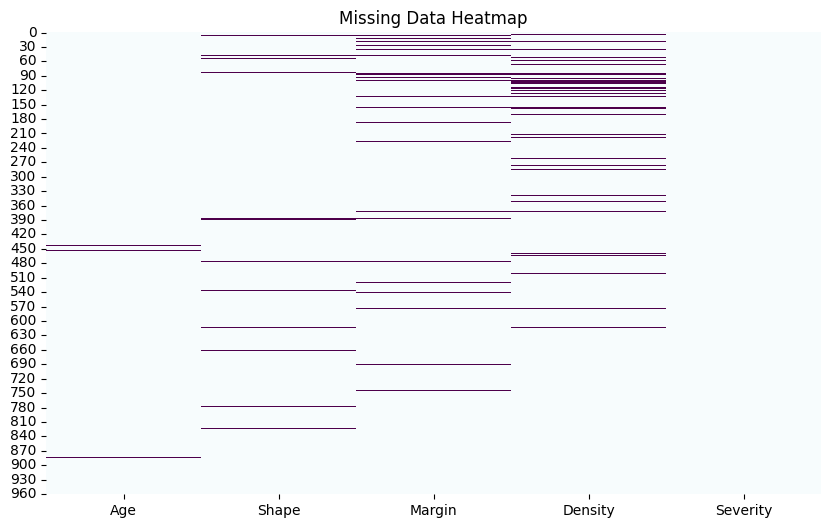

In [5]:
## Heatmap to visualize missing values

plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='BuPu')
plt.title('Missing Data Heatmap')
plt.show()

In [6]:
## Percentage of examples with missing values

rows_with_nan = data.isnull().any(axis=1).sum()

percent_unique_missing_rows = (rows_with_nan / len(data)) * 100

print(f"{percent_unique_missing_rows:.0f} %")

14 %


In [7]:
## Eliminating missing values, less than 20% of total dataset examples

df = data.dropna().reset_index(drop=True)
df

,Age,Shape,Margin,Density,Severity
0,67.0,3.0,5.0,3.0,1
1,58.0,4.0,5.0,3.0,1
2,28.0,1.0,1.0,3.0,0
3,57.0,1.0,5.0,3.0,1
4,76.0,1.0,4.0,3.0,1
...,...,...,...,...,...
826,47.0,2.0,1.0,3.0,0
827,56.0,4.0,5.0,3.0,1
828,64.0,4.0,5.0,3.0,0
829,66.0,4.0,5.0,3.0,1


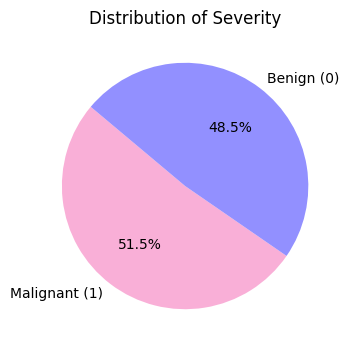

In [8]:
## Severity distribution

plt.figure(figsize=(4,4))
plt.pie(df['Severity'].value_counts(), labels=['Malignant (1)', 'Benign (0)'], autopct='%1.1f%%', startangle=140, colors=['#f9afd7ff','#9290ffff'])
plt.title('Distribution of Severity')
plt.show()

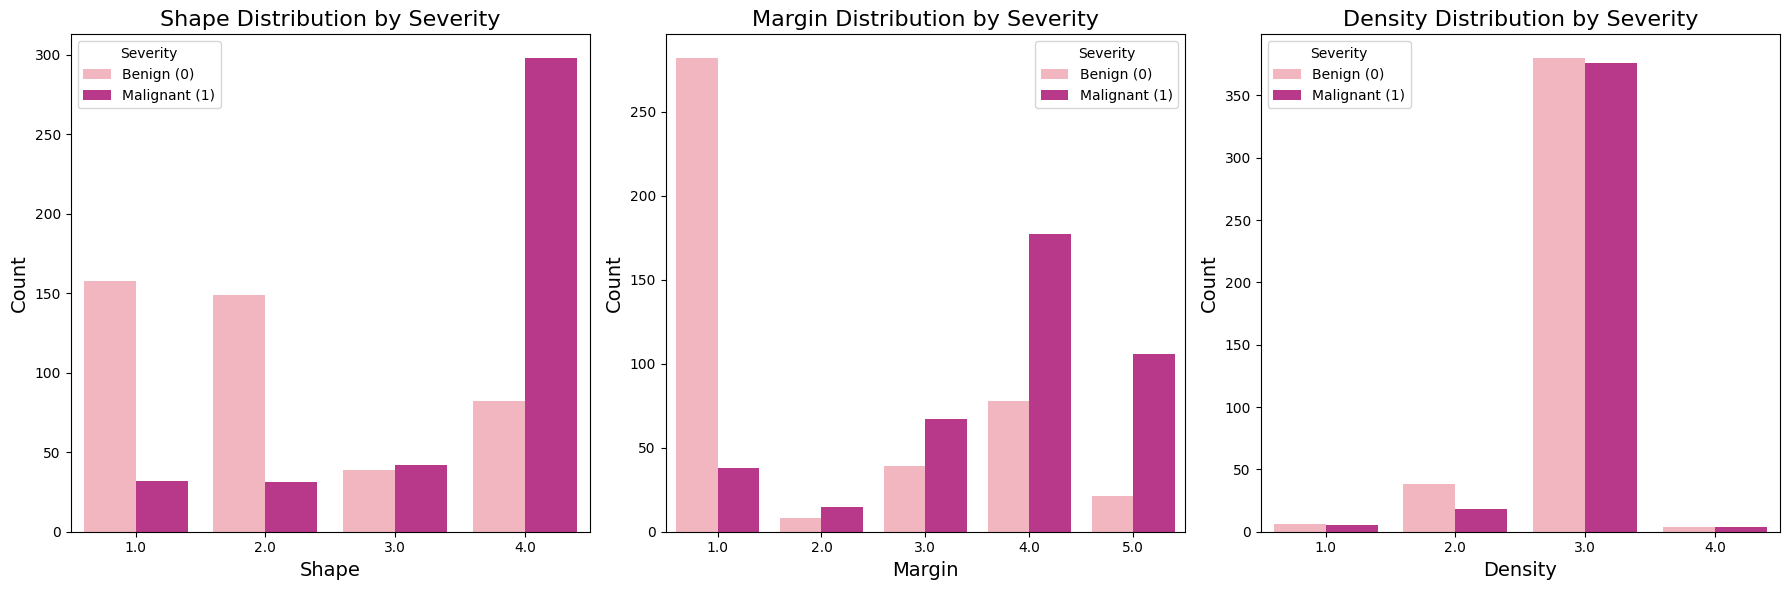

In [9]:
plt.figure(figsize=(18, 6))
for i, col in enumerate(['Shape', 'Margin', 'Density'], 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=df, x=col, hue='Severity', palette='RdPu')
    plt.title(f'{col} Distribution by Severity', fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.legend(title='Severity', labels=['Benign (0)', 'Malignant (1)'])

plt.tight_layout()
plt.show()

# margin and shape seem to be strong indicators of severity

In [10]:
## One-hot encode ordinal variables

encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(df[['Shape', 'Margin', 'Density']])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['Shape', 'Margin', 'Density']))

df_encoded = pd.concat([df[['Age']], one_hot_df, df[['Severity']]], axis=1)

print(df_encoded.shape)
df_encoded.head()

(831, 15)


,Age,Shape_1.0,Shape_2.0,Shape_3.0,Shape_4.0,Margin_1.0,Margin_2.0,Margin_3.0,Margin_4.0,Margin_5.0,Density_1.0,Density_2.0,Density_3.0,Density_4.0,Severity
0,67.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
1,58.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
2,28.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,57.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
4,76.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1


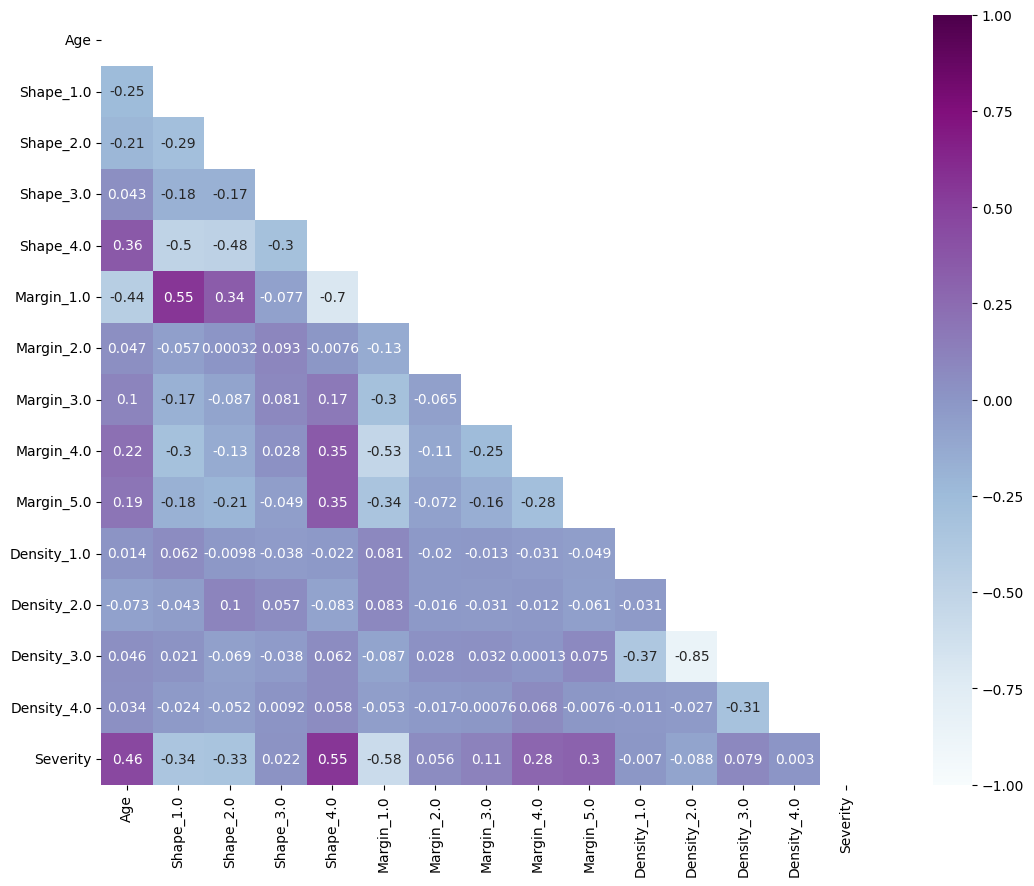

In [11]:
## Correlation matrix
plt.figure(figsize=(16, 10))
correlation_matrix = df_encoded.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

axis_corr = sns.heatmap(
correlation_matrix,
mask=mask,
vmin=-1, vmax=1, center=0,
cmap= 'BuPu',
annot=True,
square= True
)

plt.show() 

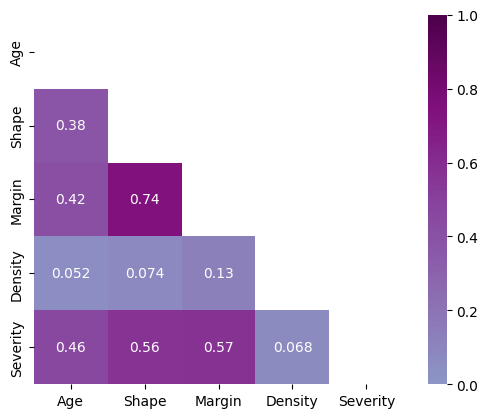

In [12]:
## Correlation matrix

correlation_matrix = df.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
axis_corr = sns.heatmap(
correlation_matrix,
mask=mask,
vmin=0, vmax=1, center=0,
cmap= 'BuPu',
annot=True,
square=True
)

plt.show() 

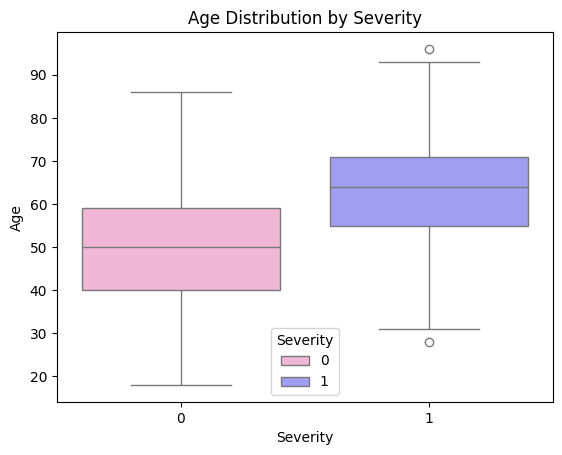

In [13]:
sns.boxplot(x='Severity', y='Age', data=df_encoded,hue='Severity',
            palette={0: '#f9afd7ff', 1: '#9290ffff'})
plt.title('Age Distribution by Severity')

plt.show()

### Model

- Logistic Regression (with Regularization)
- Support Vector Machine (SVM)
- Neural Networks

In [14]:
## X and y

X = df_encoded.drop('Severity', axis=1)
y = df_encoded['Severity']

print(X.shape)
print(y.shape)

(831, 14)
(831,)


In [15]:
## All models: scaling and splits

scaler = ColumnTransformer([
    ('age_scaler', StandardScaler(), ['Age'])
], remainder='passthrough')  # Keep other columns, just normalize age

cv = StratifiedKFold(n_splits=5)

### Should there still be a split to train and test and then do the folds on train???

### Logistic Regression

In [ ]:
## Logistic Regression

pipeline_logreg = Pipeline([
    ('scaler', scaler),
    ('logreg', LogisticRegression(max_iter=1000))
])

scores_logreg = cross_val_score(pipeline_logreg, X, y, cv=cv, scoring='accuracy')

print(f"Cross-validated accuracy scores: {scores_logreg}")
print(f"Average accuracy: {np.mean(scores_logreg):.4f}")


Cross-validated accuracy scores: [0.77844311 0.84939759 0.78915663 0.81325301 0.81927711]
Average accuracy: 0.8099


SVM Cross-validated ROC AUC scores: [0.82988803 0.90217865 0.86303558 0.87027616 0.88052326]
SVM Average ROC AUC: 0.8692
SVM ROC AUC Standard deviation: 0.0237


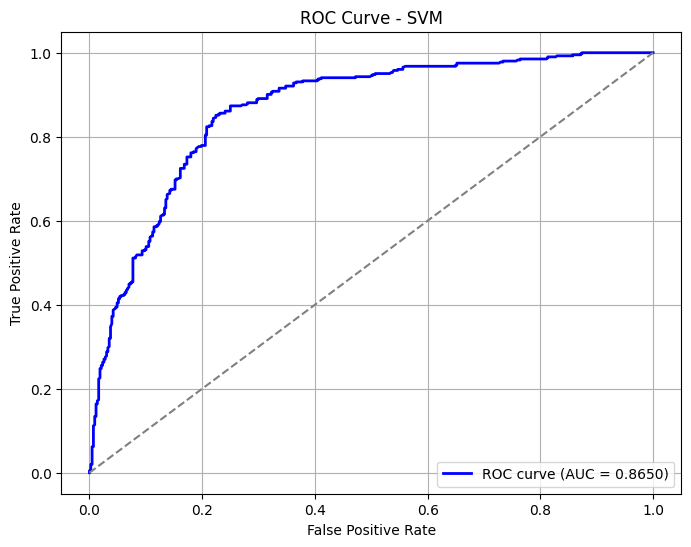

SVM Overall ROC AUC: 0.8650


In [217]:
roc_auc_scores = cross_val_score(pipeline_logreg, X, y, cv=cv, scoring='roc_auc')
print(f"SVM Cross-validated ROC AUC scores: {roc_auc_scores}")
print(f"SVM Average ROC AUC: {np.mean(roc_auc_scores):.4f}")
print(f"SVM ROC AUC Standard deviation: {np.std(roc_auc_scores):.4f}")

y_scores = cross_val_predict(pipeline_logreg, X, y, cv=cv, method="predict_proba")[:, 1]

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"SVM Overall ROC AUC: {roc_auc:.4f}")

### SVM

In [214]:
pipeline_svm = Pipeline([
    ('scaler', scaler),
    ('svm', SVC(kernel='rbf', probability=True))
])

scores_svm = cross_val_score(pipeline_svm, X, y, cv=cv, scoring='accuracy')

print(f"SVM Cross-validated accuracy scores: {scores_svm}")
print(f"SVM Average accuracy: {np.mean(scores_svm):.4f}")
print(f"SVM Standard deviation: {np.std(scores_svm):.4f}")



SVM Cross-validated accuracy scores: [0.77245509 0.8373494  0.78313253 0.80120482 0.80722892]
SVM Average accuracy: 0.8003
SVM Standard deviation: 0.0223


SVM Cross-validated ROC AUC scores: [0.7849555  0.87196805 0.83689179 0.83873547 0.85901163]
SVM Average ROC AUC: 0.8383
SVM ROC AUC Standard deviation: 0.0297


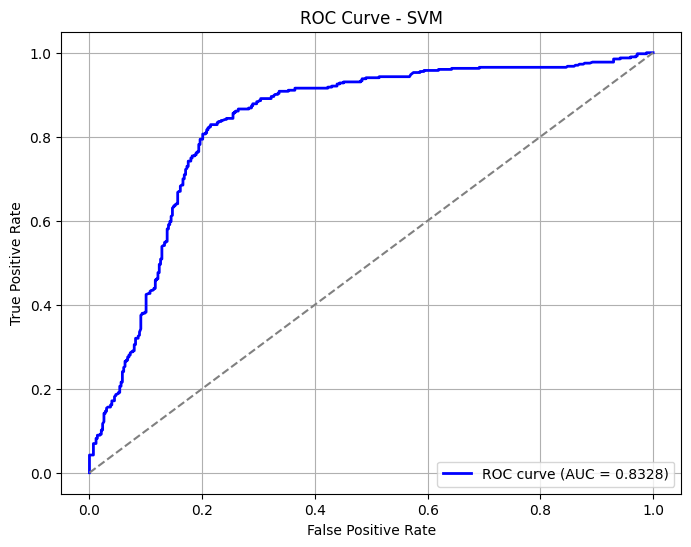

SVM Overall ROC AUC: 0.8328


In [215]:
roc_auc_scores = cross_val_score(pipeline_svm, X, y, cv=cv, scoring='roc_auc')
print(f"SVM Cross-validated ROC AUC scores: {roc_auc_scores}")
print(f"SVM Average ROC AUC: {np.mean(roc_auc_scores):.4f}")
print(f"SVM ROC AUC Standard deviation: {np.std(roc_auc_scores):.4f}")

y_scores = cross_val_predict(pipeline_svm, X, y, cv=cv, method="predict_proba")[:, 1]

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"SVM Overall ROC AUC: {roc_auc:.4f}")

In [18]:
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score
# from sklearn.model_selection import train_test_split


# dataset = load_digits()
# X, y = dataset.data, dataset.target == 1
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# # choose a classifier
# clf = SVC(kernel='rbf')

# # input grid value range
# grid_values = {'gamma': [0.001, 0.01, 0.05, 0.1, 1, 10, 100]}
# # other parameters can be input in the dictionary, e.g.,
# # grid_values = {'gamma': [0.01, 0.1, 1, 10], 'C': [0.01, 0.1, 1, 10]}
# # OR n_estimators, max_features from RandomForest
# # default metric to optimize over grid parameters: accuracy

# grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, random_state=0)

# grid_clf_acc.fit(X_train, y_train)
# y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test)

# print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
# print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

### Neural Networks

In [140]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers
from sklearn.utils import class_weight
import kerastuner as kt

In [161]:
#Setting a random seed ensures that the model produces the same results when run multiple times with the same data and configurations
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


In [211]:
#Divide the dataset into training examples, test examples and validation examples
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)


# train - 70%
# validation - 30%




In [191]:
#compute and applie class weights to handle class imbalance by assigning higher weights to underrepresented classes during model training
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


In [192]:
# Build a model with tunable units and learning rate, using ReLU activation and sigmoid output for binary classification

def build_model(hp):
    model = Sequential([
        Dense(hp.Int('units_1', min_value=32, max_value=64, step=32), activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(hp.Int('units_2', min_value=80, max_value=128, step=16), activation='relu', 
              kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [193]:
# Set up early stopping to monitor validation loss, with a patience of 10 epochs and restoring the best weights.
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [194]:
# Initialize KerasTuner with Bayesian Optimization to find the best hyperparameters based on validation accuracy, with 25 trials.

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=25,  # Número de tentativas para otimizar
    executions_per_trial=1,
    directory='tuner_results',
    project_name='NN_Optimization'
)

C:\Users\Beatrix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [195]:
# Start the hyperparameter search process using the training data, validating on the validation set for 100 epochs.
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Trial 25 Complete [00h 00m 11s]
val_accuracy: 0.8159999847412109

Best val_accuracy So Far: 0.8199999928474426
Total elapsed time: 00h 04m 38s


In [196]:
# Retrieve and print the best hyperparameters found by the tuner from the search process.
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best hyperparameters: {best_hps.values}")

Best hyperparameters: {'units_1': 32, 'units_2': 96, 'learning_rate': 0.001}


In [197]:
# Build the model with the best hyperparameters and train it for 500 epochs using class weights and validation data.

model = build_model(best_hps)
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_val, y_val),
    class_weight=class_weights
)

Epoch 1/200


C:\Users\Beatrix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4938 - loss: 3.4180 - val_accuracy: 0.4880 - val_loss: 1.2368
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4719 - loss: 2.5004 - val_accuracy: 0.4840 - val_loss: 1.1351
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4885 - loss: 2.0299 - val_accuracy: 0.5920 - val_loss: 1.0518
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4605 - loss: 1.8406 - val_accuracy: 0.5000 - val_loss: 1.0542
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4989 - loss: 1.6053 - val_accuracy: 0.6840 - val_loss: 0.9411
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5546 - loss: 1.2959 - val_accuracy: 0.7120 - val_loss: 0.9128
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5193 - loss: 1.2434 - val_accuracy: 0.5960 - val_loss: 0.9182
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5840 - loss: 1.1143 - val_accuracy: 0.6400 - val_loss: 0.8

In [198]:
# Evaluate the trained model on the test set and print the loss and accuracy results.
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.7952 - loss: 0.4726
Loss: 0.4815
Accuracy: 0.8080


In [199]:
# Predict on the test set, convert predictions to class labels, and calculate the accuracy.

from sklearn.metrics import accuracy_score
# Make predictions on the test set (or any other dataset)
y_pred = model.predict(X_val)


# Since the model uses a 'sigmoid' activation function, the predictions will be values between 0 and 1.
# For binary classification, we can set a threshold of 0.5 to classify as 0 or 1.
y_pred_class = (y_pred > 0.5).astype("int32")

# Calculate accuracy by comparing the predicted labels to the true labels
accuracy = accuracy_score(y_val, y_pred_class)
print(f"Accuracy: {accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy: 0.8080


AUC: 0.8767


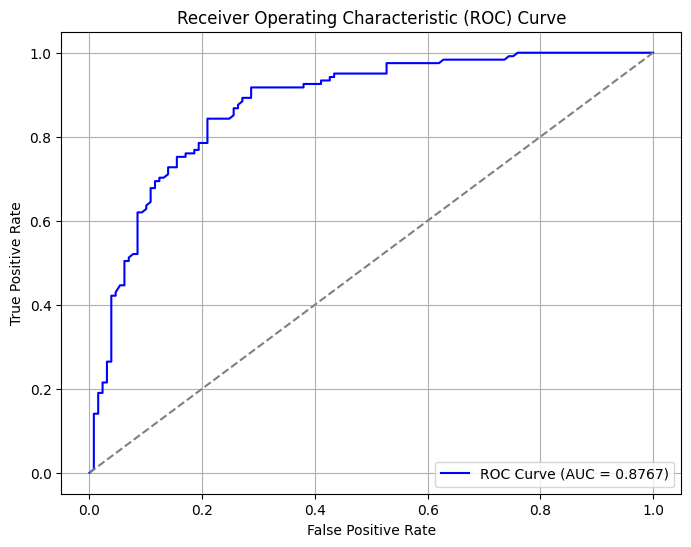

In [200]:
from sklearn.metrics import roc_auc_score, roc_curve


auc = roc_auc_score(y_val, y_pred)
print(f'AUC: {auc:.4f}')


fpr, tpr, thresholds = roc_curve(y_val, y_pred)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Final Training Error (Loss): 0.4793
Final Cross-Validation Error (Validation Loss): 0.4815


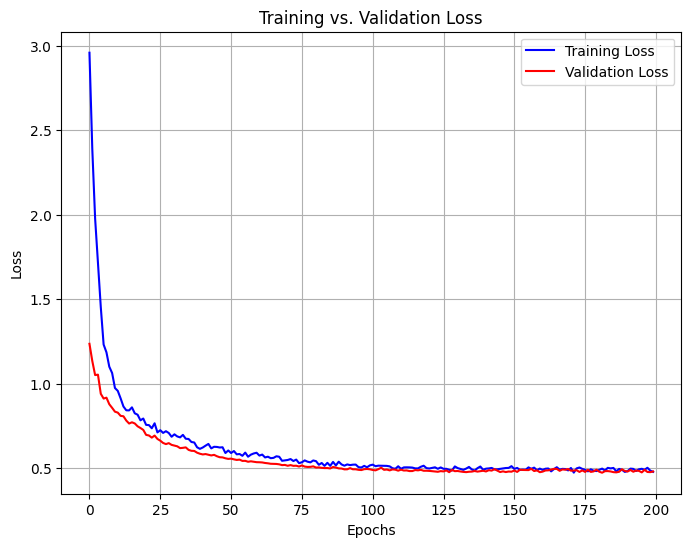

In [201]:

train_loss = history.history['loss']
val_loss = history.history['val_loss']


final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]

print(f'Final Training Error (Loss): {final_train_loss:.4f}')
print(f'Final Cross-Validation Error (Validation Loss): {final_val_loss:.4f}')



plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
